In [17]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.table import QTable
from astroquery.esasky import ESASky
from astropy.nddata import Cutout2D
from astropy.convolution import Gaussian2DKernel, convolve
from astropy import wcs
import matplotlib.pyplot as plt



In [2]:
def central_emission(hmap, map_w, pixel_w, max_sep):
    #Returns the average surface brightness in Jy/pixel of pixels within max_sep of the center of hmap (assuming hmap has units MJy/pixel)
    center = map_w + 0.5
    emission = 0
    div = 0
    hist = []
    for i in range(2*map_w):
        for j in range(2*map_w):
            if pixel_w*np.sqrt((center-i)**2+(center-j)**2) <= max_sep:
                hist.append(hmap[i,j].value)
                div +=1
    return  np.array(hist)*hmap.unit

In [3]:
hdu = fits.open('moo-alex2.fits')

In [23]:

w = wcs.WCS(hdu[0].header)
#print(w)

header = hdu[0].header
print(header)
pixel_size
print(header.get('CTYPE1'),header.get('CDELT1'),header.get('CTYPE2'),header.get('CDELT2'))

SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                  -32 / number of bits per data pixel                  NAXIS   =                    4 / number of data axes                            NAXIS1  =                  722 / length of data axis 1                          NAXIS2  =                  722 / length of data axis 2                          NAXIS3  =                    1 / length of data axis 3                          NAXIS4  =                    1 / length of data axis 4                          EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 BZERO   =   0.000000000000E+00                                                  BMAJ    =   9.143865770764E-04          

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.00000000000008 arcsec


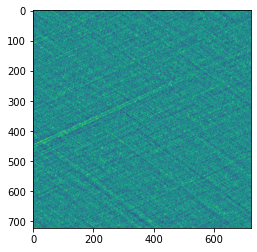

In [10]:
pixel_size = header.get('CDELT2')*u.deg

print(pixel_size.to(u.arcsec))

vmap = hdu[0].data[0][0]
plt.imshow(vmap)

In [20]:
#Convert from MJy/beam to MJy/pixel
conv_factor = np.pi*(2.5/2)**2/np.log(2)

vmap = vmap/conv_factor

#Smoothing map

filt_scale = 1*u.arcmin
beam_fwhm = 2.5*u.arcsec

smooth_scale = np.sqrt(filt_scale**2-beam_fwhm.to(u.arcmin)**2)


filt_pix = np.round(smooth_scale/(60*wcs.utils.proj_plane_pixel_scales(w)[0]*u.arcmin))
kernel = Gaussian2DKernel(x_stddev =  filt_pix)

hdata = convolve(vmap, kernel)

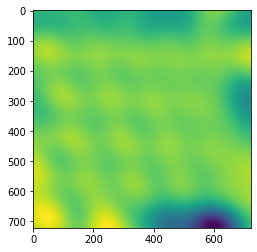

In [22]:
plt.imshow(hdata)


In [113]:
fwhm = 2.5*u.arcsec

omega_B = np.pi *(fwhm/2)**2/np.log(2)
vmap = (vmap*u.Jy/u.beam).to(u.MJy/u.sr, equivalencies=u.beam_angular_area(omega_B))

print(vmap)

[[ 0.75825775  0.805737    0.67765886 ... -1.039109   -0.8465663
  -0.53745   ]
 [ 1.1255369   0.8668463  -0.02549861 ... -1.2987608  -0.8280976
  -0.618174  ]
 [ 0.92685705  0.7849299  -0.3951805  ... -1.4674927  -0.01260792
   0.2983423 ]
 ...
 [-0.78201205 -0.08269613  0.6272118  ... -1.0677568  -1.1103181
   0.08598254]
 [-1.204654   -0.06669247  0.73542684 ... -1.0054855  -0.45582074
   0.49080238]
 [-1.5132209  -1.0226192   0.22234741 ... -0.20907284  0.17720525
  -0.07674763]] MJy / sr


In [114]:
pixel_area = (pixel_size**2).to(u.sr)

print(pixel_area)

2.3504430539101646e-11 sr


In [124]:
vmap = vmap*pixel_area
print(vmap[0,0])

1.7822417153201542e-11 MJy


[[ 1.78224172e-11  1.89383908e-11  1.59279864e-11 ... -2.44236662e-11
  -1.98980589e-11 -1.26324567e-11]
 [ 2.64551055e-11  2.03747297e-11 -5.99330427e-13 ... -3.05266333e-11
  -1.94639617e-11 -1.45298287e-11]
 [ 2.17852472e-11  1.84493306e-11 -9.28849272e-12 ... -3.44925824e-11
  -2.96341944e-13  7.01236551e-12]
 ...
 [-1.83807483e-11 -1.94372556e-12  1.47422560e-11 ... -2.50970147e-11
  -2.60973951e-11  2.02097063e-12]
 [-2.83147065e-11 -1.56756856e-12  1.72857891e-11 ... -2.36333661e-11
  -1.07138074e-11  1.15360308e-11]
 [-3.55673963e-11 -2.40360839e-11  5.22614937e-12 ... -4.91413811e-12
   4.16510836e-12 -1.80390945e-12]] MJy


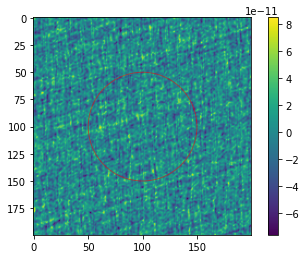

In [125]:
print(vmap)
stamp = Cutout2D(vmap, (int(723/2),int(724/2)), 200. , mode = 'strict')

fig, axes = plt.subplots()

plt.imshow(stamp.data.value)
draw_circle = plt.Circle((100, 100), 50, color = 'r',fill=False, alpha = 0.5)

plt.colorbar()

axes.set_aspect(1)
axes.add_artist(draw_circle)

In [145]:
cent_em = central_emission(stamp.data, int(100), pixel_size.to(u.arcmin).value, 1.0)


#plt.hist(cent_em.value)
#plt.hist(stamp.data.value*10**11)
#apature_area = np.pi*(1.0*u.arcmin)**2
#average_flux = cent_em[0]/apature_area

print(np.mean(cent_em), np.std(cent_em))
print(np.mean(stamp.data), np.std(stamp.data))



-9.8360474496198e-14 MJy 1.9589484548387937e-11 MJy
7.625681092441813e-14 MJy 1.9470109552388593e-11 MJy
3.508986720981988e-12 MJy / sr
